# We will determine what kind of error is present in our results
**This will be done by varying the sumsample fraction in the model, and observing the resulting variation in AUC and FPR**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [3]:
#load datapath for clean training data that is generated
datapath = '../../cleanData/csvs/resonant/'

dataset = pd.read_csv(datapath+'Tsecdata.csv')
#remove junk columns
dataset = dataset.drop(columns=['Unnamed: 0','Unnamed: 0.1'])

In [4]:
def train_test(dataset,features):
    '''divides the dataset into 80% training and 20% testing and returns training/testing sets'''
    Nrows = int(0.8*dataset.shape[0])
    train = dataset.iloc[:Nrows, :]
    test = dataset.iloc[Nrows:, :]
    #remove testing systems that go unstable in short integration phase

    test = test.drop(test[test['InitialStable']==False].index)
    return train[features], train['Stable'], test[features], test['Stable'], test['instability_time']

In [5]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']

features = near + far + megno + ['Tsec']

trainX, trainY, testX, testY, testInstability = train_test(dataset, features)


In [6]:
from sklearn import metrics
from sklearn.metrics import roc_curve, confusion_matrix, auc
def ROC_curve( model, x,y):
    preds = model.predict_proba(x)[:,1]
    fpr, tpr, ROCthresholds = roc_curve(y, preds)
    roc_auc = metrics.roc_auc_score(y, preds)
    return roc_auc, fpr, tpr, ROCthresholds

In [7]:
def getPreformance(subsamp):
    model = XGBClassifier(learning_rate = 0.05, 
                         max_depth = 13, 
                         subsample = subsamp,
                         min_child_weight = 5,
                         n_estimators = 100,
                         )
    model.fit(trainX,trainY)

    roc_auc, fpr, tpr, ROCthresholds = ROC_curve(model, testX, testY)

    tprthreshindex = np.where(tpr >=0.9)[0][0]
    falsePos = fpr[tprthreshindex]

    return subsamp, roc_auc, falsePos

In [8]:
spread = np.linspace(0.9,1.0,30)
spreadAUC = list(map(lambda x: getPreformance(x)[1], spread))
spreadFPR = list(map(lambda x: getPreformance(x)[2], spread))

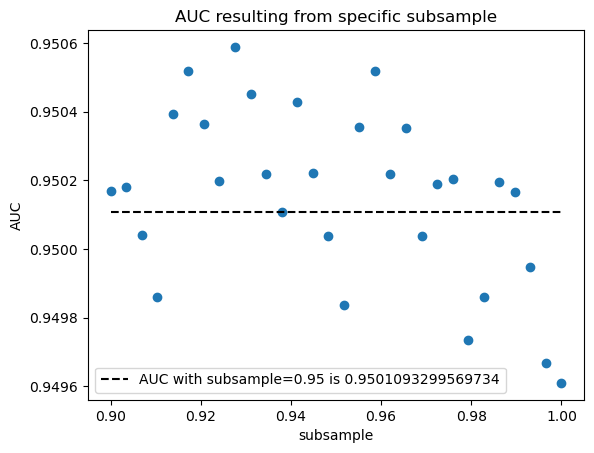

In [25]:
fig, ax = plt.subplots()
ax.scatter(spread,spreadAUC)
ax.plot([0.9, 1], [getPreformance(0.95)[1], getPreformance(0.95)[1]], 'k--', label = f"AUC with subsample=0.95 is { getPreformance(0.95)[1]}")
ax.set_xlabel('subsample')
ax.set_ylabel('AUC')
ax.set_title('AUC resulting from specific subsample')
ax.legend()

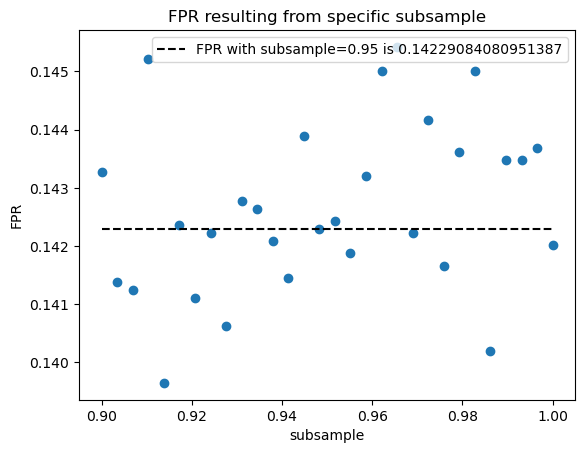

In [24]:
fig, ax = plt.subplots()
ax.scatter(spread,spreadFPR)
ax.plot([0.9, 1], [getPreformance(0.95)[2], getPreformance(0.95)[2]], 'k--',label = f"FPR with subsample=0.95 is { getPreformance(0.95)[2]}")
ax.set_xlabel('subsample')
ax.set_ylabel('FPR')
ax.set_title('FPR resulting from specific subsample')
ax.legend()

We can now determine the std of each spread

In [28]:
AUCstd = np.std(spreadAUC)
FPRstd = np.std(spreadFPR)
print(f"AUC std: {AUCstd}\nFPR std: {FPRstd}")
print(f"AUC SEM: {AUCstd/np.sqrt(30)}\nFPR SEM: {FPRstd/np.sqrt(30)}")

AUC std: 0.0002508117092033125
FPR std: 0.0014444441689426821
AUC SEM: 4.579174360569344e-05
FPR SEM: 0.00026371821812890337
